In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
import sklearn
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Load data
df = pd.read_excel('data/Monthly Mastersheet with Original Data.xlsx')
print(df.head())
print(df.columns.tolist())

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

       Month  Bitcoin  Litecoin       XRP  Ethereum  Dogecoin  Cardano  \
0 2017-09-01 -1.39892  -1.02849 -0.898590  -1.32094  -1.40502      NaN   
1 2017-10-01 -1.33954  -0.77151 -1.145490  -0.83798  -0.46490      NaN   
2 2017-11-01 -1.62299  -1.44830 -1.192080  -1.83787  -1.37105      NaN   
3 2017-12-01 -1.26767  -1.11575 -1.254630  -1.31040  -0.70209      NaN   
4 2018-01-01 -0.89251  -0.24164  0.038975  -0.81128  -0.33444      NaN   

    Tether  USD Coin  LFPR  ...     r      M1        IM        EX     CC  \
0 -3.82830       NaN  63.1  ...  1.15  3535.6  2916.022  2535.501   95.1   
1 -3.73861       NaN  62.7  ...  1.15  3615.0  3034.004  2479.107  100.7   
2 -4.01951       NaN  62.7  ...  1.16  3587.6  3034.004  2479.107   98.5   
3 -2.55687       NaN  62.7  ...  1.30  3630.5  3034.004  2479.107   95.9   
4 -2.75193       NaN  62.7  ...  1.41  3673.4  3093.299  2517.268   95.7   

        GDP  PC1_crypto  PC2_crypto    PC1_macro    PC2_macro  
0  19743.84         NaN         Na

In [ ]:
from itertools import combinations
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from IPython.display import display, HTML

def safe_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan

def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, l):
    history = list(y_train_scaled)
    preds = []
    last_model = None
    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=l, vol='GARCH', p=p, q=q, dist='normal', rescale=False)
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t])
        last_model = res
    return np.array(preds), last_model

def rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, l):
    history_y = list(y_train_scaled)
    history_x = [x.reshape(1, -1) for x in x_train_scaled]  # 2D rows
    preds = []
    last_model = None
    for t in range(len(y_test_scaled)):
        x_arr = np.vstack(history_x)
        model = arch_model(history_y, mean='ARX', lags=l, vol='GARCH', p=p, q=q, x=x_arr, dist='normal', rescale=False)
        res = model.fit(disp='off')
        const = res.params.get('Const', 0)
        phi = res.params.get('y[1]', 0)
        betas = np.array([res.params.get(f'x{i}', 0) for i in range(x_test_scaled.shape[1])])
        y_t = history_y[-1]
        x_t1 = x_test_scaled[t]
        pred = const + phi * y_t + np.dot(betas, x_t1)
        preds.append(pred)
        history_y.append(y_test_scaled[t])
        history_x.append(x_t1.reshape(1, -1))
        last_model = res
    return np.array(preds), last_model

# === CONFIG ===
macro_vars = ['LFPR', 'CPI', 'r', 'M1', 'IM', 'EX', 'CC', 'GDP']
crypto_assets = ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano']
cutoff_date = pd.to_datetime('2024-01-01')

all_results = []
best_results = []

for macro in macro_vars:
    for combo_size in range(1, 4):
        for crypto_combo in combinations(crypto_assets, combo_size):
            for p in range(1, 3):
                for q in range(0, 3):
                    for lag in range(0, 3):
                        cols = [macro] + list(crypto_combo)
                        df_temp = df[cols].copy()
                        df_temp[macro] = df_temp[macro].shift(lag)

                        # ✅ GLOBAL FIX: drop all NaNs across all selected columns
                        df_temp.dropna(inplace=True)

                        if len(df_temp) < 30 or df_temp[macro].var() == 0:
                            continue

                        df_train = df_temp[df_temp.index < cutoff_date]
                        df_test = df_temp[df_temp.index >= cutoff_date]

                        if len(df_test) == 0 or len(df_train) < 10:
                            continue

                        y_col = macro
                        x_cols = list(crypto_combo)

                        scaler_y = StandardScaler()
                        scaler_x = StandardScaler()
                        y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
                        y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
                        x_train_scaled = scaler_x.fit_transform(df_train[x_cols])
                        x_test_scaled = scaler_x.transform(df_test[x_cols])

                        try:
                            pred_ar_scaled, ar_model = rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, 1)
                            pred_arx_scaled, arx_model = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, 1)

                            pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
                            pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
                            y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
                            index_test = df_test.index

                            mse_ar = mean_squared_error(y_actual, pred_ar)
                            mse_arx = mean_squared_error(y_actual, pred_arx)
                            r2_ar = r2_score(y_actual, pred_ar)
                            r2_arx = r2_score(y_actual, pred_arx)
                            mape_ar = safe_mape(y_actual, pred_ar)
                            mape_arx = safe_mape(y_actual, pred_arx)
                            mape_change = ((mape_arx - mape_ar) / mape_ar) * 100 if mape_ar != 0 else np.nan

                            ar_const = ar_model.params.get('Const', np.nan)
                            ar_phi = ar_model.params.get('y[1]', np.nan)
                            ar_const_p = ar_model.pvalues.get('Const', np.nan)
                            ar_phi_p = ar_model.pvalues.get('y[1]', np.nan)

                            arx_const = arx_model.params.get('Const', np.nan)
                            arx_phi = arx_model.params.get('y[1]', np.nan)
                            arx_betas = np.array([arx_model.params.get(f'x{i}', np.nan) for i in range(x_test_scaled.shape[1])])
                            arx_betas_p = np.array([arx_model.pvalues.get(f'x{i}', np.nan) for i in range(x_test_scaled.shape[1])])

                            result = {
                                'Macro': macro,
                                'Crypto': crypto_combo,
                                'p': p,
                                'q': q,
                                'Lag': lag,
                                'MAPE_AR': mape_ar,
                                'MAPE_ARX': mape_arx,
                                'R2_AR': r2_ar,
                                'R2_ARX': r2_arx,
                                'MAPE_Improvement(%)': mape_change,
                                'AR_Const': ar_const,
                                'AR_Phi': ar_phi,
                                'AR_Const_pval': ar_const_p,
                                'AR_Phi_pval': ar_phi_p,
                                'ARX_Const': arx_const,
                                'ARX_Phi': arx_phi,
                                'ARX_Betas': arx_betas,
                                'ARX_Betas_pval': arx_betas_p
                            }

                            all_results.append(result)
                            if len(best_results) == 0 or mape_change < best_results[-1]['MAPE_Improvement(%)']:
                                best_results.append(result)

                        except Exception as e:
                            print(f"⚠️ Forecast failed for {macro}-{crypto_combo} lag={lag}: {e}")

# === DISPLAY ===
all_results_df = pd.DataFrame(all_results)
best_results_df = pd.DataFrame(best_results)

sorted_best = best_results_df.sort_values('MAPE_Improvement(%)')
sorted_all = all_results_df.sort_values(['Macro', 'MAPE_Improvement(%)'])

display(sorted_best)

html_all = sorted_all.to_html(index=False)
display(HTML(f'''
    <div style="max-height:500px; overflow:auto; border:1px solid #ccc; padding:10px; font-size:90%">
        {html_all}
    </div>
'''))


KeyboardInterrupt: 

In [ ]:
# === LOOP OVER EACH MACRO AS TARGET ===
for macro in macro_vars:
    for combo_size in range(1, 2):  # Only single crypto asset at a time (change to 2 if needed)
        for crypto_combo in combinations(crypto_assets, combo_size):
            for p, q in [(1, 0), (1, 1)]:  # Limit to common (p,q) pairs
                for lag in range(0, 7):  # Try lags 0, 1, 2 only
                    cols = [macro] + list(crypto_combo)
                    df_temp = df[cols].copy()
                    df_temp[macro] = df_temp[macro].shift(lag)  # apply lag to target
                    df_temp.dropna(inplace=True)

                    if len(df_temp) < 30 or df_temp[macro].var() == 0:
                        continue

                    df_train = df_temp[df_temp.index < cutoff_date]
                    df_test = df_temp[df_temp.index >= cutoff_date]

                    if len(df_test) == 0 or len(df_train) < 10:
                        continue

                    y_col = macro
                    x_cols = list(crypto_combo)

                    # Scaling
                    scaler_y = StandardScaler()
                    scaler_x = StandardScaler()
                    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
                    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
                    x_train_scaled = scaler_x.fit_transform(df_train[x_cols])
                    x_test_scaled = scaler_x.transform(df_test[x_cols])

                    try:
                        # Baseline AR
                        pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, 1)
                        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
                        y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
                        mape_ar = safe_mape(y_actual, pred_ar)

                        # Early skip if AR model is already bad
                        if mape_ar > 100:
                            continue

                        # ARX
                        pred_arx_scaled = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, 1)
                        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()

                        mse_ar = mean_squared_error(y_actual, pred_ar)
                        mse_arx = mean_squared_error(y_actual, pred_arx)
                        r2_ar = r2_score(y_actual, pred_ar)
                        r2_arx = r2_score(y_actual, pred_arx)
                        mape_arx = safe_mape(y_actual, pred_arx)
                        mape_change = ((mape_arx - mape_ar) / mape_ar) * 100 if mape_ar != 0 else np.nan

                        result = {
                            'Macro': macro,
                            'Crypto_Combo': ', '.join(crypto_combo),
                            'p': p,
                            'q': q,
                            'Crypto Lag': lag,
                            'MAPE_AR': mape_ar,
                            'MAPE_ARX': mape_arx,
                            'R2_AR': r2_ar,
                            'R2_ARX': r2_arx,
                            'MAPE_Improvement(%)': mape_change,
                        }
                        all_results.append(result)

                        existing = next((r for r in best_results if r['Macro'] == macro), None)
                        if existing is None or mape_change < existing['MAPE_Improvement(%)']:
                            best_results = [r for r in best_results if r['Macro'] != macro]
                            best_results.append(result)

                    except Exception as e:
                        print(f"⚠️ Failed for {macro} with {crypto_combo} p={p}, q={q}, lag={lag}: {e}")

# === DISPLAY RESULTS ===
all_results_df = pd.DataFrame(all_results)
best_results_df = pd.DataFrame(best_results)

# Sort and display
sorted_best = best_results_df.sort_values('MAPE_Improvement(%)')
sorted_all = all_results_df.sort_values(['Macro', 'MAPE_Improvement(%)'])

display(sorted_best)

html_all = sorted_all.to_html(index=False)
display(HTML(f'''
    <div style="max-height:500px; overflow:auto; border:1px solid #ccc; padding:10px; font-size:90%">
        {html_all}
    </div>
'''))


,Macro,Crypto_Combo,p,q,Crypto Lag,MAPE_AR,MAPE_ARX,R2_AR,R2_ARX,MAPE_Improvement(%)
0,PC1_macro,"Bitcoin, Litecoin, Ethereum",2,0,5,4.800567,2.567321,-5.114938,-0.466093,-46.520476
1,PC2_macro,"XRP, Ethereum",2,2,3,6.243417,4.179178,0.255173,0.578320,-33.062644


Macro,Crypto_Combo,p,q,Crypto Lag,MAPE_AR,MAPE_ARX,R2_AR,R2_ARX,MAPE_Improvement(%)
PC1_macro,"Bitcoin, Litecoin, Ethereum",2,0,5,4.800567,2.567321,-5.114938,-4.660928e-01,-46.520476
PC1_macro,"Bitcoin, Ethereum",2,0,5,4.800567,2.597360,-5.114938,-6.801782e-01,-45.894734
PC1_macro,"Ethereum, Dogecoin",2,0,5,4.800567,2.647678,-5.114938,-6.608805e-01,-44.846568
PC1_macro,"Litecoin, XRP, Ethereum",2,0,5,4.800567,2.657758,-5.114938,-5.181994e-01,-44.636580
PC1_macro,"Bitcoin, Ethereum, Cardano",2,0,5,4.800567,2.692662,-5.114938,-6.953733e-01,-43.909501
PC1_macro,Ethereum,2,0,5,4.800567,2.695607,-5.114938,-7.163374e-01,-43.848160
PC1_macro,"Litecoin, Ethereum",2,0,5,4.800567,2.707385,-5.114938,-5.980313e-01,-43.602804
PC1_macro,"XRP, Ethereum, Dogecoin",2,0,5,4.800567,2.714552,-5.114938,-6.828024e-01,-43.453510
PC1_macro,"Ethereum, Cardano",2,0,5,4.800567,2.722642,-5.114938,-9.098822e-01,-43.285002
PC1_macro,"Bitcoin, Ethereum, Dogecoin",2,0,5,4.800567,2.769897,-5.114938,-7.410363e-01,-42.300624


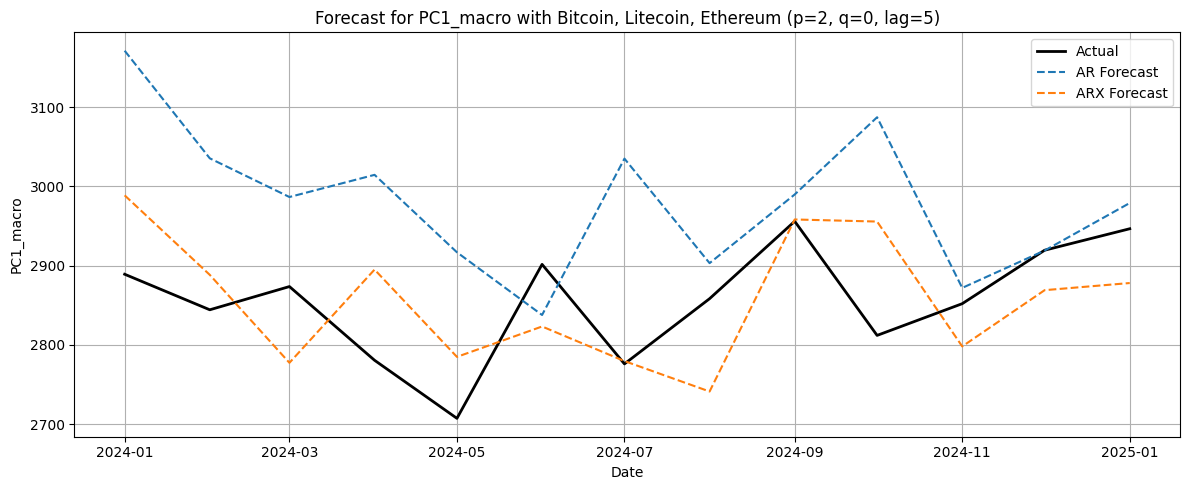

In [ ]:
import matplotlib.pyplot as plt

# Find the best result by lowest MAPE_ARX
best_row = best_results_df.sort_values('MAPE_ARX').iloc[0]

# Extract parameters
macro = best_row['Macro']
crypto_combo = best_row['Crypto_Combo'].split(', ')
p = best_row['p']
q = best_row['q']
lag = best_row['Crypto Lag']

# Rebuild data
cols = [macro] + crypto_combo
df_temp = df[cols].copy()
df_temp[macro] = df_temp[macro].shift(lag)
df_temp.dropna(inplace=True)

df_train = df_temp[df_temp.index < cutoff_date]
df_test = df_temp[df_temp.index >= cutoff_date]

y_col = macro
x_cols = crypto_combo

scaler_y = StandardScaler()
scaler_x = StandardScaler()

y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
x_train_scaled = scaler_x.fit_transform(df_train[x_cols])
x_test_scaled = scaler_x.transform(df_test[x_cols])

# Run forecasts
pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, int(p), int(q), 1)
pred_arx_scaled = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, int(p), int(q), 1)

# Inverse transform
pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_test.index, y_actual, label='Actual', color='black', linewidth=2)
plt.plot(df_test.index, pred_ar, label='AR Forecast', linestyle='--')
plt.plot(df_test.index, pred_arx, label='ARX Forecast', linestyle='--')
plt.title(f'Forecast for {macro} with {", ".join(crypto_combo)} (p={p}, q={q}, lag={lag})')
plt.xlabel('Date')
plt.ylabel(macro)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
